#### Part 3 - Jurrasic Fishbach
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

In [1]:
!git clone https://github.com/AlexYoro/CVHW.git
%cd CVHW/HW2/code/

import os
from IPython.display import clear_output
clear_output()
print(os.getcwd())

/content/CVHW/HW2/code


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy
import os
import random
from skimage.io import imread
from PIL import Image
import glob

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.

In [3]:
def video_to_image_seq(video_path, output_path ='./datasets/OTB/img/Custom/'):
  '''
  Convert a video file to a sequence of image frames. 
  Saved to a specified directory.
  ------------------------------------------------------------------------------
  Inputs:
  video_path    |    video file
  output_path   |    directory to where to save the images
  ------------------------------------------------------------------------------
  Outputs:
  Print the number of frames
  '''
  # read the video file
  os.makedirs(output_path, exist_ok=True)
  video_capture = cv2.VideoCapture(video_path)
  success, image = video_capture.read() 

  count = 0
  print("Converting video to frames...")

  '''
  Save the frames as images
  Example: 
  The first frame of the video will be saved as 0000.jpg, 
  the second frame will be saved as 0001.jpg, and so on.
  '''
  while success:

      fname = str(count).zfill(4)
      cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)
      success, image = video_capture.read()
      count += 1

  print("Number of frames: ", count)

Load our video:

In [4]:
video_path = '../data/my_data/my_video/first_try_Trim.mp4'
frames_path = '../data/my_data/output/output_frames/'
os.makedirs(frames_path, exist_ok=True)
video_to_image_seq(video_path,frames_path)

Converting video to frames...
Number of frames:  158


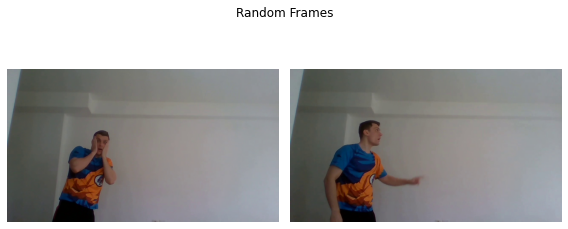

In [5]:
#Load 2 random images and store it as a variables
images = os.listdir(frames_path)
image1 = mpimg.imread(frames_path+random.choice(images))
image2 = mpimg.imread(frames_path+random.choice(images))

# Create a figure with 1 row and 2 columns, and set the title
fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)
fig.suptitle('Random Frames')

# Draw the first image on the first subplot
ax[0].imshow(image1)
ax[0].axis('off')

# Draw the second image on the second subplot
ax[1].imshow(image2)
ax[1].axis('off')

# Show the plot
plt.show()

2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.

Using DeepLabV3 segmentation

In [6]:
def deeplab3_segmentation(images_path):
  '''
  The function performs semantic segmentation on a set of images.
  ------------------------------------------------------------------------------
  Inputs:
  images_path    |    path to a directory containing the images
  ------------------------------------------------------------------------------
  Outputs:
  segmented           |    list of segmented images with a black background
  segmented_colors    |    list of segmented images with a color palette applied
  '''
  # load a pre-trained deep learning model from PyTorch Hub
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
  
  # inference mode
  model.eval();

  # define the pre-processing steps
  preprocess = transforms.Compose([
      transforms.ToTensor(), # convert the images to tensors
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalization
  ])
  
  
  frames = [dI for dI in sorted(os.listdir(images_path))] # move all paths to an array
  segmented = []
  segmented_colors = []

  for frame in frames:

    input_image = Image.open(images_path + frame)
    input_image_array = imread(images_path + frame)

    # pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)

    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # create a mask to delete background
    masked_seg = np.array(output_predictions.byte().cpu().numpy(), dtype=bool)
    input_image_array[masked_seg == 0 ] = 0
    
    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
     
    segmented_colors.append(r)
    segmented.append(input_image_array)
    
  return segmented, segmented_colors

In [7]:
segmented_frames,colored_seg_frames = deeplab3_segmentation(frames_path)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
my_video_segmented_path = "../data/my_data/output/video_segmented/"
os.makedirs(my_video_segmented_path, exist_ok=True)

In [9]:
# save images to specific directory
count = 0

for image in segmented_frames:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(my_video_segmented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

# print the total number of frames saved to the console
print("Number of frames: ", count)

Number of frames:  158


Verify that the segmentation was performed correctly.

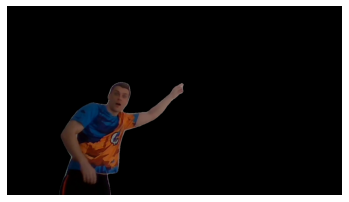

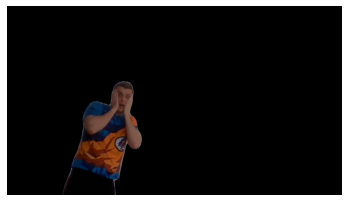

In [10]:
num_of_random = 2

for i in range(num_of_random):
  
  random_pick = random.choice([ x for x in segmented_frames])
  imgplot = plt.imshow(random_pick)
  plt.axis('off')
  plt.show()

3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?

In [11]:
# our video - UFO 
ufo_video = '../data/video_models/space_ship.mp4'

# create directories for storing frames and segmented images from a video
ufo_frames_path = '../data/my_data/output/UFO_frames/'
os.makedirs(ufo_frames_path, exist_ok=True)

ufo_segemented_path = '../data/my_data/output/UFO_segmented/'
os.makedirs(ufo_segemented_path, exist_ok=True)


In [12]:
# convert video to frames
video_to_image_seq(ufo_video,ufo_frames_path)

Converting video to frames...
Number of frames:  250


In [13]:
def resize_figure(image,scale_percent=60):
  '''
  This function takes in an image and a scaling percentage, 
  and returns a resized version of the image.
  ------------------------------------------------------------------------------
  Inputs:
  image           |    path to a directory containing the images
  scale_percent   |    degree of resizing
  ------------------------------------------------------------------------------
  Outputs:
  resized_image   |    resized image to the desired size    
  '''
  height = int(image.shape[0] * scale_percent / 100)
  width = int(image.shape[1] * scale_percent / 100)

  dim = (width, height)

  # resize image
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  return resized_image

In [14]:
from sklearn.cluster import KMeans
def kmeans_segment(images_path):

  frames = [dI for dI in sorted(os.listdir(images_path))]
  segmented=[]
  
  for frame in frames:
    pic = plt.imread(images_path+ frame)  # dividing by 255 to bring the pixel values between 0 and 1
    #resize to make it faster
    pic = resize_figure(pic,50)
    #reshape to a 3 dim stack
    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])

    kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]

    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    pic[cluster_pic == cluster_pic[0]]=0

    #resize back
    pic = resize_figure(pic,200)

    segmented.append(pic)
  return segmented

In [15]:
ufo_segmented = kmeans_segment(ufo_frames_path)

In [16]:
# save images to specific directory
count = 0

for image in ufo_segmented:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(ufo_segemented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

# print the total number of frames saved to the console
print("Number of frames: ", count)

Number of frames:  250


In [17]:
def plot_rand(num_of_frames, seg_frames):
  '''
  The function displays a number of random images from a list of images.
  ------------------------------------------------------------------------------
  Inputs:
  num_of_frames   |   number of images to display
  seg_frames      |   list of images from which to choose the images
  ------------------------------------------------------------------------------
  Outputs:
  Plot the random images  
  '''  
  for i in range(num_of_frames):

    random_pick = random.choice([ x for x in seg_frames])
    imgplot = plt.imshow(random_pick)
    
    plt.axis('off')
    plt.show()

In [18]:
def display_im(images):
  '''
  The function displays a list of images
  ------------------------------------------------------------------------------
  Inputs:
  images    |   list of images to display
  ------------------------------------------------------------------------------
  Outputs:
  Plot the images  
  '''
  fig, axes = plt.subplots(1,len(images),figsize=(15,10))
  
  for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].axis('off')

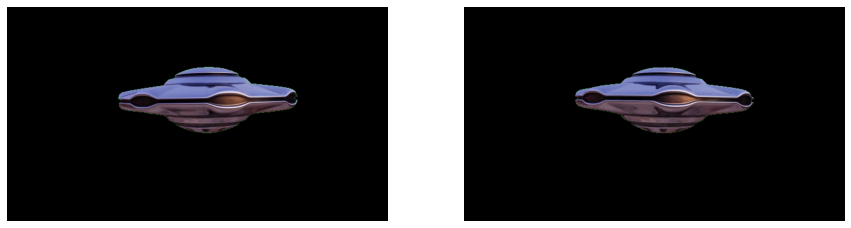

In [19]:
#print frames
images = []
for i in range(2):
  random_pick = random.choice([ x for x in ufo_segmented])
  images.append(random_pick)
display_im(images)

4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**), and upload it to YouTube (**OPTIONAL**) as instructed above.
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.

In [40]:
def image_seq_to_video(images_path, output_path='./video.mp4', fps=30):
  '''
  This function takes in a path to a directory containing a sequence of images, 
  and outputs a video file by combining these images. 
  -----------------------------------------------------------------------------------
  Inputs:
  images_path   |    path to directory cantaining a sequence of images
  output_path   |    path to directory cantaining the video
  fps           |    frames per second
  -----------------------------------------------------------------------------------
  Outputs:
  Print the number of frames
  '''
  image_array = []
  im_list = glob.glob(os.path.join(images_path, '*.jpg'))
  im_list.sort()

  for filename in im_list:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    img = cv2.resize(img, (width, height))
    height, width, layers = img.shape
    size = (width, height)
    image_array.append(img)

  print(size)
  print("Writing video...")
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
  out = cv2.VideoWriter(output_path, fourcc, fps, size)
    

  for i in range(len(image_array)):
    out.write(image_array[i])
  
  out.release()
  print("Video saved at: ", output_path)



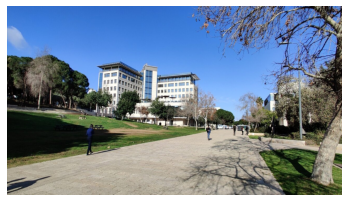

In [71]:
background = cv2.imread("../data/my_data/my_video/my_background/rsz_technion-campus-haifa-israel-3-scaled.jpg")
background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(background)

In [22]:
#myself dims
img1 = cv2.imread('../data/my_data/output/video_segmented/0000.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

print("my image size: {0}".format(img1.shape[:-1]))
print("background size: {0}".format(background.shape[:-1]))

my image size: (720, 1280)
background size: (720, 1280)


In [23]:
#UFO dims
img2 = cv2.imread('../data/my_data/output/UFO_segmented/0000.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
print("other object size: {0}".format(img2.shape[:-1]))

other object size: (720, 1280)


In [24]:
def put_forground_on_background(background, fore, x=0, y=0):

    back = background.copy()
    rows, cols, channels = fore.shape    
    trans_indices = fore[...,2] != 0 # Where not transparent
    overlay_copy = back[y:y+rows, x:x+cols] 
    overlay_copy[trans_indices] = fore[trans_indices]
    back[y:y+rows, x:x+cols] = overlay_copy
    return back

In [74]:
#important note: currently working with 4 digits frame
def create_scene(background,frame_path,opp_frame_path,out_path = './output'):
  frames = [dI for dI in sorted(os.listdir(frame_path))]
  opp_frame = [dI for dI in sorted(os.listdir(opp_frame_path))]
  scene=[]
  count=0
  for frame in frames:
    count+=1

    img1 = cv2.imread(frame_path +'/'+ frame)
    me = resize_figure(img1,100)
    #img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    back = put_forground_on_background(background, me, 0, 0)

    img2 = cv2.imread(opp_frame_path + '/'+frame)
    #img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
    ufo = resize_figure(img2,25)
    back = put_forground_on_background(back, ufo, 800-count, 200-count)

    #if (count > 100 ):
    #  ufo = cv2.cvtColor(ufo,cv2.COLOR_RGB2HSV)
    #  ufo[:,:,1] = ufo[:,:,1] * count/145
    #  ufo[:,:,0] = ufo[:,:,0] * count/100
    #  ufo[:,:,2] = ufo[:,:,2] * 1.2
    #  ufo = cv2.cvtColor(ufo,cv2.COLOR_HSV2RGB)
    #  ufo[:,:,0] = ufo[:,:,0] * count/140
    #  back = put_forground_on_background(back, ufo, 1100+count, count)
    #else:
    #  back = put_forground_on_background(back, ufo, 100, 100)
    scene.append(back)

  os.makedirs(out_path, exist_ok=True)
  count = 0
  for image in scene:
      fname = str(count).zfill(4)
      image = image[:, :, ::-1].copy() 
      cv2.imwrite(os.path.join(out_path, fname + ".jpg"), image)  # save frame as JPEG file 
      count += 1
  return scene

In [75]:
output_frames_path = '../data/my_data/output/scene_frames/' 
os.makedirs(output_frames_path, exist_ok=True)
scene_video_path = '../data/my_data/output/final.mp4'
os.makedirs(scene_video_path, exist_ok=True)

#UFO
scene = create_scene(background, my_video_segmented_path, ufo_segemented_path, out_path= output_frames_path)

In [2]:
random_frames=[]
for i in range(2):
  random_pick = random.choice([ x for x in scene])
  random_frames.append(random_pick)
display_im(random_frames)

NameError: ignored

In [1]:
image_seq_to_video(output_frames_path, fps=30)

NameError: ignored

In [70]:
from IPython.display import HTML
from base64 import b64encode

# Input video path
save_path = "/content/CVHW/HW2/code/video.mp4"

# Compressed video path
compressed_path = "/content/CVHW/HW2/code/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)